In [2]:
import tensorflow as tf
print("TF version:", tf.__version__)
print("Listing GPUs...")
print(tf.config.list_physical_devices('GPU'))
print("Done")


TF version: 2.10.1
Listing GPUs...
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Done


In [ ]:
    import tensorflow as tf
    import pandas as pd
    import os
    import json
    from sklearn.model_selection import train_test_split
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.models import Model, load_model
    from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, Input
    from tensorflow.keras.optimizers import Adam
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    from tensorflow.keras.regularizers import l2
    
    # -----------------------------
    # GPU Setup
    # -----------------------------
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.set_visible_devices(gpus[0], 'GPU')
            tf.config.experimental.set_memory_growth(gpus[0], True)
            device = '/GPU:0'
            print(f"Using GPU: {gpus[0]}")
        except:
            device = '/CPU:0'
    else:
        device = '/CPU:0'
        print("Using CPU")
    
    # -----------------------------
    # Dataset Path (Single Folder)
    # -----------------------------
    dataset_dir = r"D:\Final_Semester_Project\AI_Attendance_System\ai-ml-model\DataSets\FullProcessedAgumented"
    
    # -----------------------------
    # Create DataFrame of Images
    # -----------------------------
    filepaths = []
    labels = []
    
    for label in os.listdir(dataset_dir):
        class_dir = os.path.join(dataset_dir, label)
        if os.path.isdir(class_dir):
            for file in os.listdir(class_dir):
                filepaths.append(os.path.join(class_dir, file))
                labels.append(label)
    
    df = pd.DataFrame({
        'filepath': filepaths,
        'label': labels
    })
    
    print("Total images found:", len(df))
    
    # -----------------------------
    # Split dataset (sklearn)
    # -----------------------------
    train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['label'], random_state=42)
    val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)
    
    print("Train:", len(train_df), " Val:", len(val_df), " Test:", len(test_df))
    
    # -----------------------------
    # Generators
    # -----------------------------
    img_size = (112,112)
    batch_size = 16
    
    datagen = ImageDataGenerator(rescale=1./255)
    
    train_gen = datagen.flow_from_dataframe(
        train_df, x_col='filepath', y_col='label',
        target_size=img_size, class_mode='categorical', batch_size=batch_size
    )
    
    val_gen = datagen.flow_from_dataframe(
        val_df, x_col='filepath', y_col='label',
        target_size=img_size, class_mode='categorical', batch_size=batch_size
    )
    
    test_gen = datagen.flow_from_dataframe(
        test_df, x_col='filepath', y_col='label',
        target_size=img_size, class_mode='categorical', batch_size=batch_size, shuffle=False
    )
    
    num_classes = len(train_gen.class_indices)
    print("Number of classes:", num_classes)
    
    # -----------------------------
    # Model
    # -----------------------------
    checkpoint_path = "checkpoints/best_model.keras"
    weight_decay = 1e-4
    
    with tf.device(device):
        if os.path.exists(checkpoint_path):
            print("Loading checkpoint model…")
            model = load_model(checkpoint_path)
        else:
            inputs = Input(shape=(112,112, 3))
            
            x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(inputs)
            x = BatchNormalization()(x)
            x = Conv2D(32, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(2,2)(x)
            x = Dropout(0.3)(x)
    
            x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
            x = BatchNormalization()(x)
            x = Conv2D(64, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(2,2)(x)
            x = Dropout(0.3)(x)
    
            x = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
            x = BatchNormalization()(x)
            x = Conv2D(128, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(2,2)(x)
            x = Dropout(0.4)(x)
    
            x = Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
            x = BatchNormalization()(x)
            x = Conv2D(256, (3,3), activation='relu', padding='same', kernel_regularizer=l2(weight_decay))(x)
            x = BatchNormalization()(x)
            x = MaxPooling2D(2,2)(x)
            x = Dropout(0.4)(x)
    
            x = GlobalAveragePooling2D()(x)
            x = Dense(512, activation='relu', kernel_regularizer=l2(weight_decay))(x)
            x = Dropout(0.6)(x)
            x = Dense(256, activation='relu', kernel_regularizer=l2(weight_decay))(x)
            x = Dropout(0.6)(x)
    
            outputs = Dense(num_classes, activation='softmax')(x)
    
            model = Model(inputs, outputs)
    
            model.compile(
                optimizer=Adam(0.0005),
                loss='categorical_crossentropy',
                metrics=['accuracy']
            )
    
    # -----------------------------
    # Callbacks
    # -----------------------------
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.3)
    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, monitor='val_loss')
    
    # -----------------------------
    # Train
    # -----------------------------
    history = model.fit(train_gen, validation_data=val_gen, epochs=50,
                        callbacks=[early_stop, reduce_lr, checkpoint])
    
    # -----------------------------
    # Test Evaluation
    # -----------------------------
    test_loss, test_acc = model.evaluate(test_gen)
    print("Test accuracy:", test_acc)
    
    # -----------------------------
    # Save final model & labels
    # -----------------------------
    model.save("face_recognition_attendance_final.keras")
    model.save("face_recognition_attendance_final.h5")
    
    with open("class_labels.json", "w") as f:
        json.dump(train_gen.class_indices, f)
    
    print("Model + labels saved successfully.")


Using GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Total images found: 270000
Train: 189000  Val: 40500  Test: 40500
Found 189000 validated image filenames belonging to 540 classes.
Found 40500 validated image filenames belonging to 540 classes.
Found 40500 validated image filenames belonging to 540 classes.
Number of classes: 540
Epoch 1/50
  376/11813 [..............................] - ETA: 44:55 - loss: 6.5341 - accuracy: 0.0027       

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_recall_curve,
    roc_curve,
    auc,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize
import seaborn as sns
        

## Get Predictions & True Labels

In [5]:
# Predict probabilities
y_prob = model.predict(test_gen)

# True labels (integer encoded)
y_true = test_gen.classes

# Predicted class labels
y_pred = np.argmax(y_prob, axis=1)

class_names = list(test_gen.class_indices.keys())
num_classes = len(class_names)


138/138 [==============================] - 3s 21ms/step


## Confusion Matrix

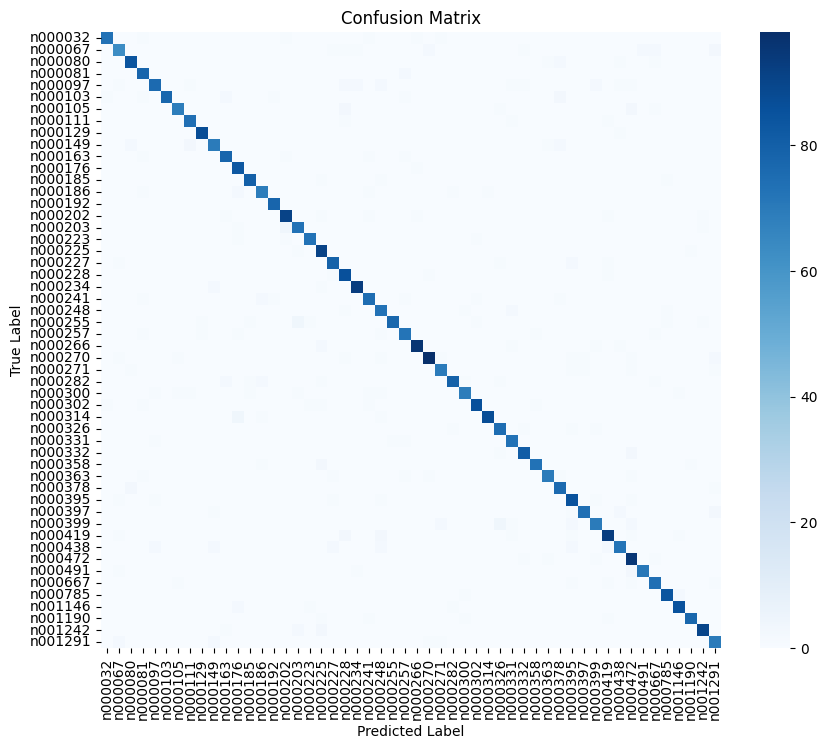

In [13]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# ✅ SAVE IMAGE
plt.savefig(
    "confusion_matrix.png",
    dpi=300,
    bbox_inches="tight"
)

plt.show()


## Classification Report (Precision, Recall, F1)

In [7]:
print(classification_report(
    y_true,
    y_pred,
    target_names=class_names
))


              precision    recall  f1-score   support

     n000032       0.97      0.94      0.95        78
     n000067       0.89      0.83      0.86        76
     n000080       0.93      0.94      0.94        89
     n000081       0.91      0.97      0.94        80
     n000097       0.94      0.84      0.89        90
     n000103       1.00      0.90      0.94        86
     n000105       0.96      0.90      0.93        77
     n000111       0.94      0.96      0.95        77
     n000129       0.98      0.99      0.98        88
     n000149       0.91      0.90      0.90        78
     n000163       0.93      0.95      0.94        82
     n000176       0.88      0.99      0.93        84
     n000185       0.96      0.96      0.96        83
     n000186       0.92      0.92      0.92        75
     n000192       0.97      1.00      0.99        78
     n000202       0.93      0.94      0.93        97
     n000203       0.90      0.92      0.91        79
     n000223       0.96    

## Precision–Recall Curve (Micro-Average)

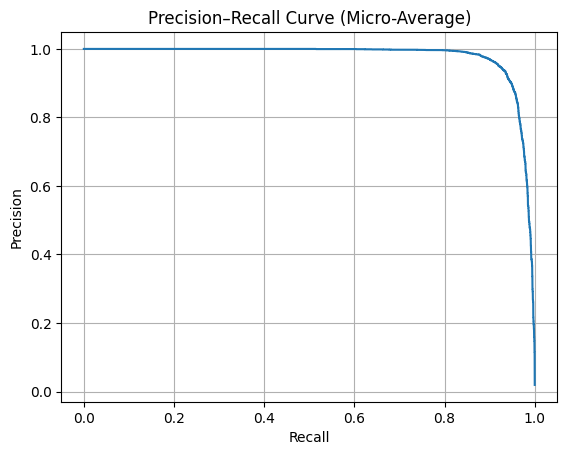

In [14]:
y_true_bin = label_binarize(y_true, classes=range(num_classes))

precision, recall, thresholds = precision_recall_curve(
    y_true_bin.ravel(),
    y_prob.ravel()
)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Micro-Average)")
plt.grid()
plt.savefig(
    "Precison_Recall_Curve(Micro-Average).png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


## F1-Score vs Threshold Curve

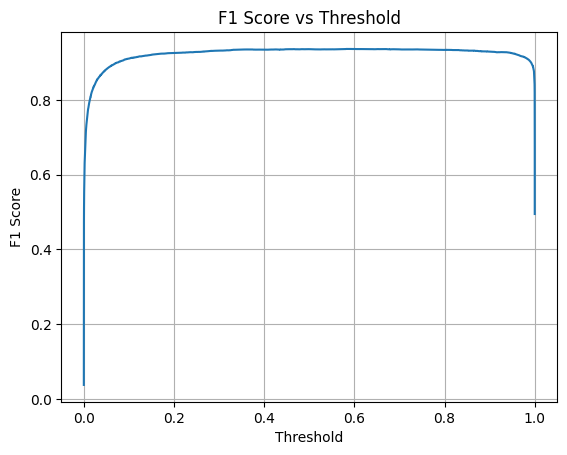

In [9]:
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)

plt.figure()
plt.plot(thresholds, f1_scores[:-1])
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.title("F1 Score vs Threshold")
plt.grid()
plt.show()


## Recall vs Threshold Curve

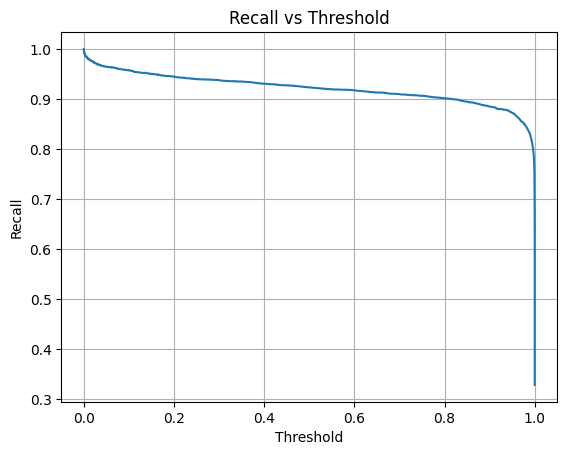

In [10]:
plt.figure()
plt.plot(thresholds, recall[:-1])
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Recall vs Threshold")
plt.grid()
plt.show()


## ROC Curve + AUC (Micro-Average)

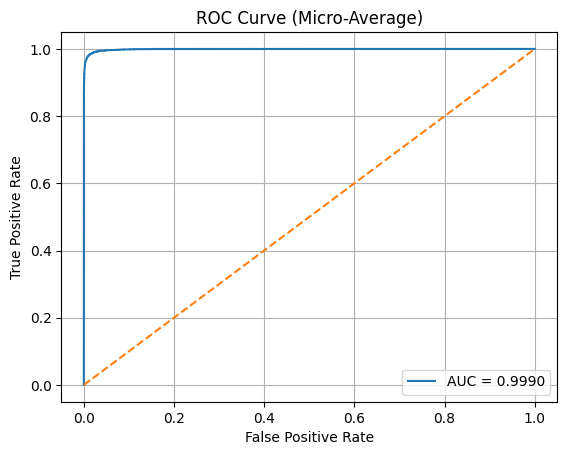

In [15]:
fpr, tpr, _ = roc_curve(
    y_true_bin.ravel(),
    y_prob.ravel()
)

roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Micro-Average)")
plt.legend()
plt.grid()
plt.savefig(
    "ROC_Curve(Micro-Average).png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


## AUC Score (Numeric)

In [12]:
auc_score = roc_auc_score(
    y_true_bin,
    y_prob,
    average="micro"
)

print("ROC AUC Score (Micro-Average):", auc_score)


ROC AUC Score (Micro-Average): 0.9990014763204528
